# 1. Cài đặt & tham số chung

In [1]:
# !pip install pandas numpy scikit-learn matplotlib tensorflow --quiet

import os, gc, math, json, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, Model

In [2]:
# ==== Reproducibility ====
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# ==== Config ====
DATA_PATH = "../Dataset/retail_store_inventory.csv"  # <- sửa nếu cần

In [6]:
STORE_ID = "S001"      # có thể đổi
PRODUCT_ID = "P0005"   # có thể đổi

LOOKBACK = 28          # số ngày nhìn lại
HORIZON  = 14          # 7 hoặc 14
BATCH_SIZE = 64
EPOCHS = 100
LR = 1e-3              # 1e-3 hoặc 5e-4

USE_SAMPLE_WEIGHT = True   # cân bằng dịp lễ
HOLIDAY_WEIGHT = 3.0       # mức trọng số khi có holiday trong cửa sổ dự báo

RUN_STAMP = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_NAME = "LSTM"

In [7]:
# Thư mục output
os.makedirs("runs", exist_ok=True)
os.makedirs("preds", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

In [8]:
print(tf.__version__)

2.19.0


# 2. Đọc dữ liệu & chuẩn hóa cột thời gian

In [9]:
df = pd.read_csv(DATA_PATH)

In [10]:
# Chuẩn cột thời gian
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

In [11]:
# Kiểm tra nhanh
display(df.head(3))
print("Rows:", len(df), "| Date range:", df["Date"].min().date(), "→", df["Date"].max().date())

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
72,2022-01-01,S004,P0013,Furniture,East,191,56,65,54.47,61.81,0,Sunny,0,63.92,Autumn
71,2022-01-01,S004,P0012,Electronics,North,349,9,165,0.95,14.25,5,Rainy,1,18.56,Spring


Rows: 73100 | Date range: 2022-01-01 → 2024-01-01


# 3. Chọn chuỗi (Store, Product) & reindex ngày

In [14]:
# Lọc 1 chuỗi theo (Store, Product)
d = (
    df[(df["Store ID"] == STORE_ID) & (df["Product ID"] == PRODUCT_ID)]
      .sort_values("Date")
      .set_index("Date")
)

# Reindex theo ngày liên tục
full_idx = pd.date_range(d.index.min(), d.index.max(), freq="D")
d = d.reindex(full_idx)

In [15]:
# Điền thiếu hợp lý
# Target (Units Sold): điền 0 nếu vắng
d["Units Sold"] = d["Units Sold"].fillna(0)

In [16]:
# Inventory Level: forward-fill
if "Inventory Level" in d.columns:
    d["Inventory Level"] = d["Inventory Level"].ffill().fillna(0)

In [17]:
# Các số khác: giữ nguyên / điền median nếu cần
for col in ["Price", "Competitor Pricing", "Demand Forecast", "Discount", "Units Ordered"]:
    if col in d.columns:
        d[col] = d[col].fillna(d[col].median())

In [18]:
# Biến nhị phân holiday
if "Holiday/Promotion" in d.columns:
    d["Holiday/Promotion"] = d["Holiday/Promotion"].fillna(0).astype(int)
else:
    d["Holiday/Promotion"] = 0

In [19]:
# Lưu các cột nhận dạng (fill forward string nếu thiếu)
for cat in ["Store ID", "Product ID", "Category", "Region", "Weather Condition", "Seasonality"]:
    if cat in d.columns:
        d[cat] = d[cat].ffill().bfill()

In [20]:
display(d.head(3))
print("Final length:", len(d))

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
2022-01-02,S001,P0005,Electronics,East,238,200,40,204.30,23.76,15,Sunny,1,19.19,Summer
2022-01-03,S001,P0005,Groceries,West,368,165,56,170.76,95.54,0,Sunny,0,91.29,Spring


Final length: 731


# 4. Tạo đặc trưng (one-hot + calendar)

In [21]:
# Calendar features
feat = d.copy()
feat["dow"] = feat.index.dayofweek
feat["month"] = feat.index.month

In [22]:
# Cột phân loại để one-hot
CAT_COLS = ["Weather Condition", "Seasonality", "Region", "Category"]
CAT_COLS = [c for c in CAT_COLS if c in feat.columns]

feat = pd.get_dummies(feat, columns=CAT_COLS, drop_first=True)

# Numeric features (giữ gốc để scale)
NUM_COLS = ["Price", "Discount", "Demand Forecast", "Competitor Pricing", "Inventory Level"]
NUM_COLS = [c for c in NUM_COLS if c in feat.columns]

In [23]:
# Đảm bảo các cột tồn tại
TARGET_COL = "Units Sold"
all_feature_cols = (
    NUM_COLS
    + [c for c in feat.columns if c.startswith("Weather Condition_")]
    + [c for c in feat.columns if c.startswith("Seasonality_")]
    + [c for c in feat.columns if c.startswith("Region_")]
    + [c for c in feat.columns if c.startswith("Category_")]
    + ["dow", "month", "Holiday/Promotion"]  # holiday dùng cả làm weight lẫn feature
)
all_feature_cols = [c for c in all_feature_cols if c in feat.columns]

In [25]:
# Khung dữ liệu hoàn chỉnh cho modeling
model_df = feat[[TARGET_COL] + all_feature_cols].copy().dropna()

In [26]:
model_df.index.name = "Date"

In [27]:
display(model_df.head())
print("Num features:", len(all_feature_cols))

,Units Sold,Price,Discount,Demand Forecast,Competitor Pricing,Inventory Level,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,...,Region_North,Region_South,Region_West,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys,dow,month,Holiday/Promotion
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,14,73.64,0,9.26,68.95,166,False,False,True,False,...,False,False,False,True,False,False,False,5,1,0
2022-01-02,200,23.76,15,204.30,19.19,238,False,False,True,False,...,False,False,False,True,False,False,False,6,1,1
2022-01-03,165,95.54,0,170.76,91.29,368,False,False,True,True,...,False,False,True,False,False,True,False,0,1,0
2022-01-04,32,69.65,10,45.57,73.50,470,False,True,False,True,...,False,False,False,True,False,False,False,1,1,0
2022-01-05,192,46.13,0,193.38,42.56,405,False,False,False,True,...,False,False,True,False,True,False,False,2,1,0


Num features: 21


# Chia Train/Val/Test theo thời gian & Scale (fit trên train)

In [28]:
# Tách theo thời gian: 70% train, 15% val, 15% test (bạn có thể chỉnh theo ngày cụ thể)
n = len(model_df)
n_train = int(n * 0.70)
n_val   = int(n * 0.85)

train_df = model_df.iloc[:n_train]
val_df   = model_df.iloc[n_train:n_val]
test_df  = model_df.iloc[n_val:]

In [29]:
# Scaler cho features & target (fit trên train)
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_raw = train_df[all_feature_cols].values
y_train_raw = train_df[[TARGET_COL]].values
x_scaler.fit(X_train_raw)
y_scaler.fit(y_train_raw)

def scale_xy(df_):
    X = x_scaler.transform(df_[all_feature_cols].values)
    y = y_scaler.transform(df_[[TARGET_COL]].values)
    return X, y

Xtr, ytr = scale_xy(train_df)
Xva, yva = scale_xy(val_df)
Xte, yte = scale_xy(test_df)

h_train = train_df["Holiday/Promotion"].values if "Holiday/Promotion" in train_df.columns else np.zeros(len(train_df))
h_val   = val_df["Holiday/Promotion"].values   if "Holiday/Promotion" in val_df.columns else np.zeros(len(val_df))
h_test  = test_df["Holiday/Promotion"].values  if "Holiday/Promotion" in test_df.columns else np.zeros(len(test_df))

print("Shapes:", Xtr.shape, ytr.shape, Xva.shape, yva.shape, Xte.shape, yte.shape)

Shapes: (511, 21) (511, 1) (110, 21) (110, 1) (110, 21) (110, 1)


# 6. Hàm tạo cửa sổ (lookback → horizon) & sample weight

In [30]:
def make_windows(X, y, holidays, lookback=28, horizon=14, use_weight=True, holiday_weight=3.0):
    Xw, yw, w = [], [], []
    T = len(y)
    for t in range(lookback, T - horizon + 1):
        Xw.append(X[t - lookback:t, :])
        yw.append(y[t:t + horizon, 0])

        if use_weight:
            hol = holidays[t:t + horizon]
            weight = 1.0 + (holiday_weight - 1.0) * (hol.mean())
        else:
            weight = 1.0
        w.append(weight)

    return np.asarray(Xw, np.float32), np.asarray(yw, np.float32), np.asarray(w, np.float32)

Xtr_w, ytr_w, wtr = make_windows(Xtr, ytr, h_train, LOOKBACK, HORIZON, USE_SAMPLE_WEIGHT, HOLIDAY_WEIGHT)
Xva_w, yva_w, wva = make_windows(Xva, yva, h_val,   LOOKBACK, HORIZON, USE_SAMPLE_WEIGHT, HOLIDAY_WEIGHT)
Xte_w, yte_w, wte = make_windows(Xte, yte, h_test,  LOOKBACK, HORIZON, USE_SAMPLE_WEIGHT, HOLIDAY_WEIGHT)

print("Windowed:", Xtr_w.shape, ytr_w.shape, "| Val:", Xva_w.shape, yva_w.shape, "| Test:", Xte_w.shape, yte_w.shape)

Windowed: (470, 28, 21) (470, 14) | Val: (69, 28, 21) (69, 14) | Test: (69, 28, 21) (69, 14)


# 7. Xây dựng model LSTM (64→Dropout→32→Dense(horizon))

In [31]:
def build_lstm(n_features, horizon, lookback=28, lr=1e-3):
    inp = layers.Input(shape=(lookback, n_features))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32)(x)
    out = layers.Dense(horizon)(x)

    opt = optimizers.Adam(learning_rate=lr, clipnorm=1.0)

    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    def smape(y_true, y_pred, eps=1e-6):
        denom = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + eps
        return tf.reduce_mean(tf.abs(y_true - y_pred) / denom)

    model = Model(inp, out)
    model.compile(optimizer=opt, loss="mse", metrics=[rmse, smape])
    return model

model = build_lstm(n_features=Xtr_w.shape[-1], horizon=HORIZON, lookback=LOOKBACK, lr=LR)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 28, 64)              │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             462 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,894 (136.30 KB)

 Trainable params: 34,894 (136.30 KB)

 Non-trainable params: 0 (0.00 B)

# 8. Train (EarlyStopping, ReduceLROnPlateau, TensorBoard)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1936 - rmse: 0.3146 - smape: 1.2431 - val_loss: 0.0592 - val_rmse: 0.2510 - val_smape: 0.7606 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1134 - rmse: 0.2409 - smape: 0.7573 - val_loss: 0.0480 - val_rmse: 0.2313 - val_smape: 0.7287 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1008 - rmse: 0.2267 - smape: 0.7323 - val_loss: 0.0473 - val_rmse: 0.2273 - val_smape: 0.7243 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0985 - rmse: 0.2243 - smape: 0.7299 - val_loss: 0.0475 - val_rmse: 0.2273 - val_smape: 0.7228 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0982 - rmse: 0.2239 - smape: 0.7300 - val_loss: 0.0462 - val_rmse: 0.2253 - val_smape: 0.7182 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0970 - rmse: 0.2224 - smape: 0.7249 - val_loss: 0.

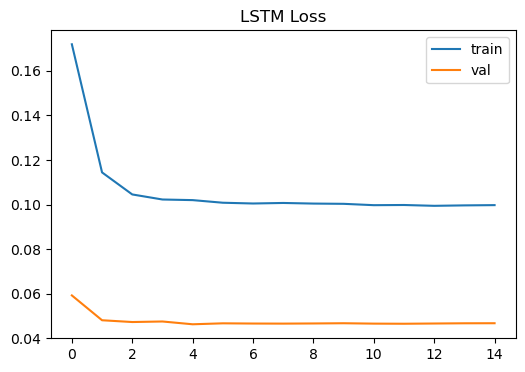

In [32]:
LOG_DIR = f"runs/tensorboard/lstm_{RUN_STAMP}"
os.makedirs(LOG_DIR, exist_ok=True)

cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=5e-5),
    callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0)
]

hist = model.fit(
    Xtr_w, ytr_w,
    validation_data=(Xva_w, yva_w),
    sample_weight=wtr if USE_SAMPLE_WEIGHT else None,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    verbose=1,
    callbacks=cbs
)

pd.DataFrame(hist.history).to_csv(f"runs/history_lstm_{RUN_STAMP}.csv", index=False)

plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("LSTM Loss"); plt.legend(); plt.show()

# 9. Đánh giá trên Test (RMSE, sMAPE) & dự báo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Test RMSE : 105.0087
Test sMAPE: 0.7017


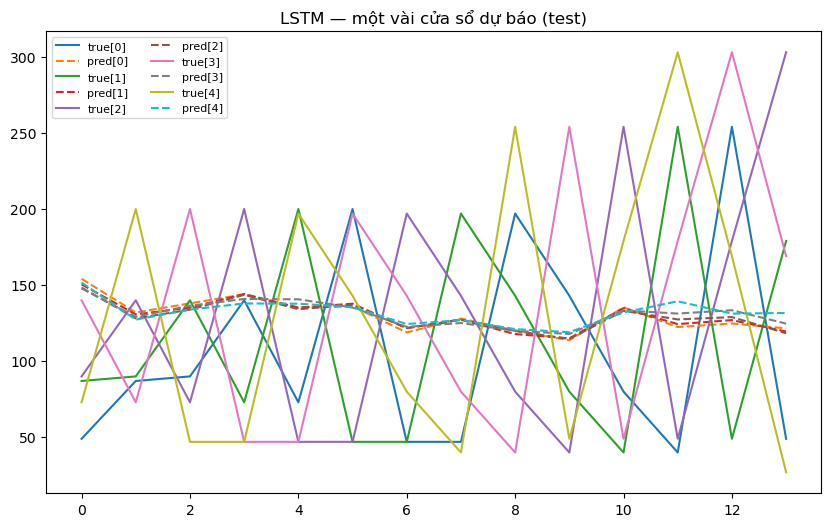

In [33]:
y_pred_test = model.predict(Xte_w)

# Inverse scale
y_pred_test_inv = y_scaler.inverse_transform(y_pred_test)
y_test_inv      = y_scaler.inverse_transform(yte_w)

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
def smape_np(y_true, y_pred, eps=1e-6):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + eps
    return np.mean(np.abs(y_true - y_pred) / denom)

print(f"Test RMSE : {rmse_np(y_test_inv, y_pred_test_inv):.4f}")
print(f"Test sMAPE: {smape_np(y_test_inv, y_pred_test_inv):.4f}")

k = min(5, len(y_test_inv))
plt.figure(figsize=(10,6))
for i in range(k):
    plt.plot(y_test_inv[i], label=f"true[{i}]")
    plt.plot(y_pred_test_inv[i], "--", label=f"pred[{i}]")
plt.title("LSTM — một vài cửa sổ dự báo (test)")
plt.legend(ncol=2, fontsize=8); plt.show()

# 10. Lưu mô hình + scaler + config (Keras 3: .keras)

In [34]:
SAVE_DIR = os.path.join("artifacts", f"lstm_{RUN_STAMP}")
os.makedirs(SAVE_DIR, exist_ok=True)

# Lưu model
model.save(os.path.join(SAVE_DIR, "lstm_model.keras"))     # chuẩn Keras 3

# Lưu scaler
import joblib
joblib.dump(x_scaler, os.path.join(SAVE_DIR, "x_scaler.pkl"))
joblib.dump(y_scaler, os.path.join(SAVE_DIR, "y_scaler.pkl"))

# Lưu config
with open(os.path.join(SAVE_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump({
        "model_name": "LSTM",
        "store_id": STORE_ID,
        "product_id": PRODUCT_ID,
        "lookback": LOOKBACK,
        "horizon": HORIZON,
        "features": all_feature_cols,
        "target": TARGET_COL,
        "run_stamp": RUN_STAMP,
        "epochs_trained": len(hist.history["loss"]),
    }, f, indent=2, ensure_ascii=False)

print("Saved to:", SAVE_DIR)

Saved to: artifacts\lstm_20251111-220457


# 11. Suy luận tương lai & xuất CSV

In [35]:
# Lấy cửa sổ cuối cùng để dự báo HORIZON ngày tiếp theo
last_block = model_df.iloc[-LOOKBACK:].copy()
X_last = x_scaler.transform(last_block[all_feature_cols].values)
X_last = np.expand_dims(X_last, axis=0)

y_future_scaled = model.predict(X_last)[0]        # (HORIZON,)
y_future = y_scaler.inverse_transform(y_future_scaled.reshape(-1,1)).ravel()

start_date = model_df.index[-1] + pd.Timedelta(days=1)
future_idx = pd.date_range(start_date, periods=HORIZON, freq="D")

pred_df = pd.DataFrame({"date": future_idx, "forecast_units_sold": y_future})
display(pred_df.head())

out_path = f"preds/lstm_pred_{STORE_ID}_{PRODUCT_ID}_H{HORIZON}_{RUN_STAMP}.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
pred_df.to_csv(out_path, index=False)
print("Saved forecast to:", out_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


,date,forecast_units_sold
0,2024-01-02,140.754913
1,2024-01-03,102.951775
2,2024-01-04,126.389954
3,2024-01-05,148.437927
4,2024-01-06,143.444458


Saved forecast to: preds/lstm_pred_S001_P0005_H14_20251111-220457.csv


# 12. Rolling-origin backtest nhanh

In [36]:
def rolling_origin_bt_lstm(all_df, features, target, lookback=28, horizon=14, folds=3, lr=1e-3, epochs=30, batch_size=64):
    from sklearn.preprocessing import MinMaxScaler
    mets = []
    n = len(all_df)
    fold_size = (n - (lookback + horizon)) // (folds + 1)

    for f in range(folds):
        train_end = (f + 1) * fold_size
        val_end   = train_end + fold_size

        tr = all_df.iloc[:train_end]
        te = all_df.iloc[train_end - lookback : val_end + horizon]

        xs = MinMaxScaler().fit(tr[features].values)
        ys = MinMaxScaler().fit(tr[[target]].values)

        X_tr = xs.transform(tr[features].values); y_tr = ys.transform(tr[[target]].values)
        X_te = xs.transform(te[features].values); y_te = ys.transform(te[[target]].values)

        hol_tr = tr["Holiday/Promotion"].values if "Holiday/Promotion" in tr.columns else np.zeros(len(tr))
        hol_te = te["Holiday/Promotion"].values if "Holiday/Promotion" in te.columns else np.zeros(len(te))

        # windows
        def make_windows(X, y, holidays, lookback=28, horizon=14):
            Xw, yw = [], []
            T = len(y)
            for t in range(lookback, T - horizon + 1):
                Xw.append(X[t - lookback:t, :])
                yw.append(y[t:t + horizon, 0])
            return np.asarray(Xw, np.float32), np.asarray(yw, np.float32)

        Xtr_, ytr_ = make_windows(X_tr, y_tr, hol_tr, lookback, horizon)
        Xte_, yte_ = make_windows(X_te, y_te, hol_te, lookback, horizon)

        m = build_lstm(n_features=Xtr_.shape[-1], horizon=horizon, lookback=lookback, lr=lr)
        m.fit(Xtr_, ytr_, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=0)

        yp = m.predict(Xte_)
        yp_inv = ys.inverse_transform(yp)
        yt_inv = ys.inverse_transform(yte_)

        def rmse_np(a,b): return np.sqrt(np.mean((a-b)**2))
        def smape_np(a,b,eps=1e-6): return np.mean(np.abs(a-b)/((np.abs(a)+np.abs(b))/2+eps))

        mets.append((rmse_np(yt_inv, yp_inv), smape_np(yt_inv, yp_inv)))
        tf.keras.backend.clear_session(); gc.collect()
    return mets

bt = rolling_origin_bt_lstm(model_df[[TARGET_COL] + all_feature_cols], all_feature_cols, TARGET_COL,
                            lookback=LOOKBACK, horizon=HORIZON, folds=3, lr=LR, epochs=max(10, EPOCHS//3), batch_size=BATCH_SIZE)
for i,(r,s) in enumerate(bt,1):
    print(f"Fold {i}: RMSE={r:.4f} | sMAPE={s:.4f}")
print("Avg RMSE:", np.mean([x[0] for x in bt]), "| Avg sMAPE:", np.mean([x[1] for x in bt]))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Fold 1: RMSE=121.0631 | sMAPE=0.7642
Fold 2: RMSE=106.7109 | sMAPE=0.7163
Fold 3: RMSE=110.4271 | sMAPE=0.7417
Avg RMSE: 112.7337 | Avg sMAPE: 0.7407264
